# Symmetry Class β-VAE (Beta Variational Autoencoder) Study

This notebook aims to reconstruct symmetry patterns from the `symmetry_dataset` folder using the **Beta-VAE** model and validate on the `test` folder.

**What is β-VAE?**
Beta-VAE is an extended version of the standard VAE. By applying the β (beta) hyperparameter to the KL divergence term:
- **β > 1**: More disentangled latent representations are learned
- **β < 1**: Reconstruction quality is prioritized
- **β = 1**: Standard VAE behavior

The training and evaluation workflow is organized step by step.


## Table of Contents
1. Setup and configuration
2. Dataset preparation
3. Beta-VAE model architecture
4. Loss function (Reconstruction + β × KL Divergence)
5. Training and early stopping
6. **Beta-VAE Analysis and Visualizations**
   - Loss components chart (Recon vs KL)
   - Latent space visualization (t-SNE)
   - Latent traversal (dimension exploration)
   - Random sampling
7. Test set validation
8. Class-wise reconstruction analysis


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. Copy file to local Colab runtime (Daha hızlı I/O için önce kopyala)
!cp "/content/drive/MyDrive/dataset.zip" "/content/dataset.zip"

# 2. Unzip (Quiet mode '-q' çıktıyı gizler, '-d' destination belirtir)
!unzip -q "/content/dataset.zip" -d "/content/"

# 3. Remove the zip file to save space (Disk clean-up)
!rm "/content/dataset.zip"

In [3]:
!mv /content/dataset/* /content/

In [4]:
import os
import random
from pathlib import Path
import json
from typing import Optional

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.style.use("ggplot")


def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


SEED = 42
set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(f"Active device: {DEVICE}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(DEVICE)}")


Active device: cuda
CUDA device: Tesla T4


In [5]:
def resolve_base_dir() -> Path:
    candidates = []
    env_base = os.environ.get("SYMMETRY_BASE_DIR")
    if env_base:
        candidates.append(Path(env_base).expanduser())

    notebook_dir = Path.cwd().resolve()
    candidates.extend([
        notebook_dir,
        notebook_dir.parent,
        Path.home() / "Desktop" / "research",
    ])

    for candidate in candidates:
        if candidate is None:
            continue
        candidate = candidate.expanduser().resolve()
        train_dir = candidate / "symmetry_dataset"
        test_dir = candidate / "test"
        if train_dir.exists() and test_dir.exists():
            return candidate

    print(
        "Warning: 'symmetry_dataset' and/or 'test' folders not found. "
        "Please update 'BASE_DIR' value or set 'SYMMETRY_BASE_DIR' environment variable."
    )
    return notebook_dir

BASE_DIR = resolve_base_dir()
IS_WINDOWS = os.name == "nt"

CONFIG = {
    "train_root": BASE_DIR / "symmetry_dataset",
    "test_root": BASE_DIR / "test",
    "output_dir": BASE_DIR / "artifacts",
    "image_size": (256, 256),
    "num_channels": 3,
    "normalize": True,
    "batch_size": 32,
    "num_workers": 0,  # To prevent multiprocessing issues in Jupyter notebook
    "pin_memory": torch.cuda.is_available(),
    "val_split": 0.1,
    "epochs": 30,
    "learning_rate": 1e-3,
    "weight_decay": 1e-5,
    "max_grad_norm": 5.0,
    "patience": 5,
    "max_train_samples": 85000,
    "max_test_samples": None,
    "latent_channels": 64,
    "base_channels": 32,
    "seed": SEED,
    "beta": 1,
}

CONFIG["in_channels"] = CONFIG["num_channels"]
if CONFIG["normalize"]:
    CONFIG["normalize_mean"] = [0.5] * CONFIG["num_channels"]
    CONFIG["normalize_std"] = [0.5] * CONFIG["num_channels"]
else:
    CONFIG["normalize_mean"] = None
    CONFIG["normalize_std"] = None

CONFIG["output_dir"].mkdir(parents=True, exist_ok=True)

print(
    json.dumps(
        {k: (str(v) if isinstance(v, Path) else v) for k, v in CONFIG.items()},
        indent=2,
        ensure_ascii=False,
    )
)


{
  "train_root": "/content/symmetry_dataset",
  "test_root": "/content/test",
  "output_dir": "/content/artifacts",
  "image_size": [
    256,
    256
  ],
  "num_channels": 3,
  "normalize": true,
  "batch_size": 32,
  "num_workers": 0,
  "pin_memory": true,
  "val_split": 0.1,
  "epochs": 30,
  "learning_rate": 0.001,
  "weight_decay": 1e-05,
  "max_grad_norm": 5.0,
  "patience": 5,
  "max_train_samples": 85000,
  "max_test_samples": null,
  "latent_channels": 64,
  "base_channels": 32,
  "seed": 42,
  "beta": 1,
  "in_channels": 3,
  "normalize_mean": [
    0.5,
    0.5,
    0.5
  ],
  "normalize_std": [
    0.5,
    0.5,
    0.5
  ]
}


In [6]:
# Pickleable functions for multiprocessing compatibility
def convert_to_rgb(img):
    return img.convert("RGB")

def convert_to_grayscale(img):
    return img.convert("L")


def build_transforms(config: dict) -> transforms.Compose:
    items = []
    num_channels = config.get("num_channels", 3)
    if num_channels == 3:
        items.append(transforms.Lambda(convert_to_rgb))
    elif num_channels == 1:
        items.append(transforms.Lambda(convert_to_grayscale))
    else:
        raise ValueError(f"Unsupported number of channels: {num_channels}")
    items.append(transforms.Resize(config["image_size"], antialias=True))
    items.append(transforms.ToTensor())
    if config["normalize"]:
        items.append(transforms.Normalize(mean=config["normalize_mean"], std=config["normalize_std"]))
    return transforms.Compose(items)


def create_dataloaders(config: dict):
    transform = build_transforms(config)

    train_full = datasets.ImageFolder(config["train_root"], transform=transform)
    test_full = datasets.ImageFolder(config["test_root"], transform=transform)
    class_names = train_full.classes

    if config["max_train_samples"] is not None:
        sample_size = min(config["max_train_samples"], len(train_full))
        indices = random.sample(range(len(train_full)), k=sample_size)
        train_full = Subset(train_full, indices)

    if config["max_test_samples"] is not None:
        sample_size = min(config["max_test_samples"], len(test_full))
        indices = random.sample(range(len(test_full)), k=sample_size)
        test_full = Subset(test_full, indices)

    val_size = int(len(train_full) * config["val_split"])
    if val_size == 0 and len(train_full) > 1:
        val_size = 1
    train_size = len(train_full) - val_size
    if train_size <= 0:
        raise ValueError("No training data left; please review `max_train_samples` or `val_split` values.")

    train_subset, val_subset = random_split(
        train_full,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(config["seed"]),
    )

    loader_kwargs = {
        "batch_size": config["batch_size"],
        "num_workers": config["num_workers"],
        "pin_memory": config["pin_memory"],
    }

    train_loader = DataLoader(train_subset, shuffle=True, **loader_kwargs)
    val_loader = DataLoader(val_subset, shuffle=False, **loader_kwargs) if val_size > 0 else None
    test_loader = DataLoader(test_full, shuffle=False, **loader_kwargs)

    metadata = {
        "class_names": class_names,
        "train_size": len(train_subset),
        "val_size": len(val_subset) if val_loader is not None else 0,
        "test_size": len(test_full),
    }

    return train_loader, val_loader, test_loader, metadata, transform


def denormalize(tensor: torch.Tensor, mean, std) -> torch.Tensor:
    if mean is None or std is None:
        return tensor.clamp(0.0, 1.0)
    mean = torch.tensor(mean, device=tensor.device).view(1, -1, 1, 1)
    std = torch.tensor(std, device=tensor.device).view(1, -1, 1, 1)
    return tensor * std + mean


def show_batch(loader: DataLoader, config: dict, title: str = "Training Data Sample", max_images: int = 16):
    images, labels = next(iter(loader))
    images = images[:max_images]
    labels = labels[:max_images]

    images = denormalize(images, config["normalize_mean"], config["normalize_std"]).cpu()
    grid = utils.make_grid(images, nrow=int(max_images ** 0.5), pad_value=1.0)
    grid_np = grid.permute(1, 2, 0).numpy()

    if grid_np.shape[2] == 1:
        grid_np = grid_np.squeeze(-1)
        cmap = "gray"
    else:
        cmap = None

    plt.figure(figsize=(8, 8))
    plt.imshow(grid_np, cmap=cmap)
    plt.axis("off")
    plt.title(title)
    plt.show()



Training samples: 76500
Validation samples: 8500
Test samples: 355
Number of classes: 17


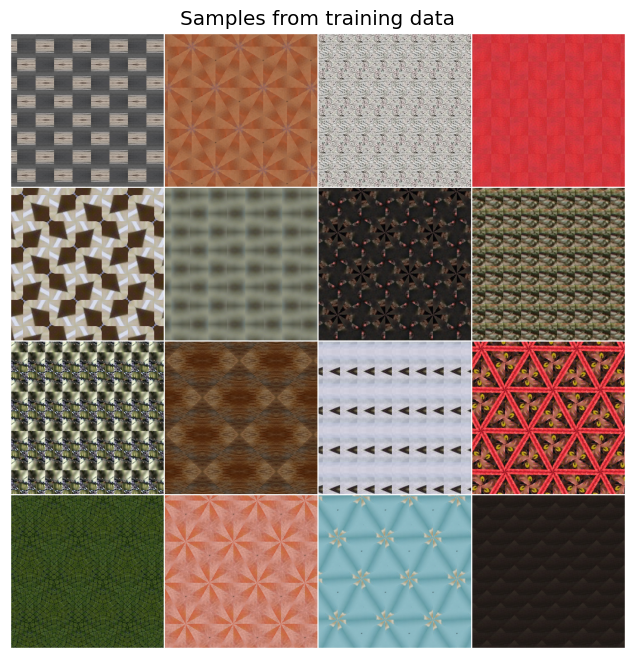

In [13]:
train_loader, val_loader, test_loader, metadata, _ = create_dataloaders(CONFIG)

print(f"Training samples: {metadata['train_size']}")
print(f"Validation samples: {metadata['val_size']}")
print(f"Test samples: {metadata['test_size']}")
print(f"Number of classes: {len(metadata['class_names'])}")

show_batch(train_loader, CONFIG, title="Samples from training data")


In [14]:
class BetaVAE(nn.Module):
    def __init__(
        self,
        in_channels: int,
        base_channels: int = 32,
        latent_channels: int = 64,
        output_activation: str = "tanh",
    ) -> None:
        super().__init__()

        if output_activation == "tanh":
            activation = nn.Tanh()
        elif output_activation == "sigmoid":
            activation = nn.Sigmoid()
        elif output_activation == "identity":
            activation = nn.Identity()
        else:
            raise ValueError(f"Unsupported output activation: {output_activation}")

        # Encoder Body: Same as original, except for the last layer
        self.encoder_body = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_channels * 2, base_channels * 4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Encoder Head: Using groups=2 to maintain parameter count.
        # Input: 128 channels, Output: 128 channels (64 mu + 64 logvar)
        # With groups=2, parameter count equals the original (128 * 64) layer.
        self.encoder_head = nn.Conv2d(
            base_channels * 4,
            latent_channels * 2,
            kernel_size=3,
            stride=2,
            padding=1,
            groups=2
        )
        self.encoder_bn = nn.BatchNorm2d(latent_channels * 2)

        # Decoder: Identical to original
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, base_channels * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(base_channels, in_channels, kernel_size=4, stride=2, padding=1),
            activation,
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def forward(self, x: torch.Tensor):
        # Encoding
        h = self.encoder_body(x)
        encoded = self.encoder_bn(self.encoder_head(h))

        # Split latent variables (Split channels)
        mu, logvar = torch.chunk(encoded, 2, dim=1)

        # Reparameterization Trick
        z = self.reparameterize(mu, logvar)

        # Decoding
        reconstruction = self.decoder(z)

        return reconstruction, mu, logvar

def count_parameters(model: nn.Module) -> int:
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

In [15]:
output_activation = "tanh" if CONFIG["normalize"] else "sigmoid"
model = BetaVAE(
    in_channels=CONFIG["in_channels"],
    base_channels=CONFIG["base_channels"],
    latent_channels=CONFIG["latent_channels"],
    output_activation=output_activation,
).to(DEVICE)

param_count = count_parameters(model)
print(f"Model parameters: {param_count:,}")
# Original model was ~464,739 parameters. This model will be ~464,931. Difference is only 192 (BN parameters).

Model parameters: 464,931


In [16]:
def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    # 1. Reconstruction Loss (MSE)
    # Mean squared error between images (per-pixel error)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')

    # 2. KL Divergence
    # Analytical formula: -0.5 * sum(1 + log(var) - mu^2 - var)
    # This is summed over all batch and latent dimensions
    kld_sum = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # 3. CRITICAL POINT: Normalization (Scaling)
    # KLD is currently a very large number (summed over Batch_Size * Latent_Dim).
    # To make it comparable with MSE (mean), we divide by the number of pixels.
    # num_pixels = Batch_Size * Channels * Height * Width
    num_pixels = x.numel()

    # Convert KLD to per-pixel error
    kld_per_pixel = kld_sum / num_pixels

    # 4. Total Loss
    # Now both are on "per-pixel" scale, so beta=1.0 provides a true balance.
    # beta > 1.0 increases disentanglement.
    loss = recon_loss + beta * kld_per_pixel

    return loss, recon_loss, kld_per_pixel

def evaluate_loss(model: nn.Module, loader: DataLoader, config: dict) -> float:
    model.eval()
    total_loss = 0.0
    sample_count = 0
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(DEVICE, non_blocking=True)
            recon, mu, logvar = model(images)
            loss, _, _ = vae_loss_function(recon, images, mu, logvar, beta=config["beta"])

            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            sample_count += batch_size
    return total_loss / max(1, sample_count)

def evaluate_loss_detailed(model: nn.Module, loader: DataLoader, config: dict) -> tuple:
    """Calculates VAE loss and its components separately."""
    model.eval()
    total_loss, total_recon, total_kld = 0.0, 0.0, 0.0
    sample_count = 0
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(DEVICE, non_blocking=True)
            recon, mu, logvar = model(images)
            loss, recon_loss, kld_loss = vae_loss_function(recon, images, mu, logvar, beta=config["beta"])

            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            total_recon += recon_loss.item() * batch_size
            total_kld += kld_loss.item() * batch_size
            sample_count += batch_size

    n = max(1, sample_count)
    return total_loss / n, total_recon / n, total_kld / n


def train_autoencoder(model: nn.Module, train_loader: DataLoader, val_loader: Optional[DataLoader], config: dict):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"],
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"])

    # Detailed history for Beta-VAE: total loss, recon loss, kl loss
    history = {
        "train_loss": [], "train_recon": [], "train_kld": [],
        "val_loss": [], "val_recon": [], "val_kld": []
    }
    best_val_loss = float("inf")
    best_state = None
    patience_counter = 0

    for epoch in range(1, config["epochs"] + 1):
        model.train()
        running_loss, running_recon, running_kld = 0.0, 0.0, 0.0
        sample_count = 0

        progress = tqdm(train_loader, desc=f"Epoch {epoch}/{config['epochs']} - training", leave=False)
        for images, _ in progress:
            images = images.to(DEVICE, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            # Forward pass (reconstruction, mean, logvariance)
            recon, mu, logvar = model(images)

            # Loss calculation
            loss, recon_loss, kld_loss = vae_loss_function(recon, images, mu, logvar, beta=config["beta"])

            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=config["max_grad_norm"])
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size
            running_recon += recon_loss.item() * batch_size
            running_kld += kld_loss.item() * batch_size
            sample_count += batch_size

            # Show details in progress bar
            progress.set_postfix(loss=loss.item(), recon=recon_loss.item(), kld=kld_loss.item())

        n = max(1, sample_count)
        train_loss = running_loss / n
        train_recon = running_recon / n
        train_kld = running_kld / n

        history["train_loss"].append(train_loss)
        history["train_recon"].append(train_recon)
        history["train_kld"].append(train_kld)

        val_loss = None
        if val_loader is not None:
            val_loss, val_recon, val_kld = evaluate_loss_detailed(model, val_loader, config)
            history["val_loss"].append(val_loss)
            history["val_recon"].append(val_recon)
            history["val_kld"].append(val_kld)

            if val_loss < best_val_loss - 1e-5:
                best_val_loss = val_loss
                patience_counter = 0
                best_state = {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": epoch,
                    "val_loss": best_val_loss,
                    "config": {k: (str(v) if isinstance(v, Path) else v) for k, v in config.items()},
                }
                checkpoint_path = CONFIG["output_dir"] / "best_autoencoder.pt"
                torch.save(best_state, checkpoint_path)
            else:
                patience_counter += 1
        else:
            history["val_loss"].append(None)
            history["val_recon"].append(None)
            history["val_kld"].append(None)
            patience_counter = 0

        scheduler.step()

        print(f"Epoch {epoch}: loss={train_loss:.6f} (recon={train_recon:.6f}, β×kld={config['beta']*train_kld:.6f})" +
              (f" | val_loss={val_loss:.6f}" if val_loss is not None else ""))

        if val_loader is not None and patience_counter >= config["patience"]:
            print("Early stopping triggered.")
            break

    if best_state is None:
        best_state = {"model": model.state_dict()}
    return history, best_state

## Running the Training Loop

The following cell starts the full training loop. Training time depends on the selected number of samples and your hardware. If you need to stop training, you can manually terminate the execution.


In [17]:
%%time
history, best_state = train_autoencoder(model, train_loader, val_loader, CONFIG)


Epoch 1/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 1: loss=0.070950 (recon=0.051767, β×kld=0.019183) | val_loss=0.046682


Epoch 2/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 2: loss=0.053259 (recon=0.040093, β×kld=0.013166) | val_loss=0.041148


Epoch 3/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 3: loss=0.049130 (recon=0.036101, β×kld=0.013029) | val_loss=0.040304


Epoch 4/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 4: loss=0.047098 (recon=0.034061, β×kld=0.013037) | val_loss=0.038115


Epoch 5/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 5: loss=0.045720 (recon=0.032753, β×kld=0.012967) | val_loss=0.037220


Epoch 6/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 6: loss=0.044973 (recon=0.032069, β×kld=0.012904) | val_loss=0.036555


Epoch 7/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 7: loss=0.044105 (recon=0.031246, β×kld=0.012859) | val_loss=0.036297


Epoch 8/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 8: loss=0.043683 (recon=0.030854, β×kld=0.012829) | val_loss=0.036556


Epoch 9/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 9: loss=0.043423 (recon=0.030603, β×kld=0.012820) | val_loss=0.036116


Epoch 10/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 10: loss=0.043059 (recon=0.030252, β×kld=0.012807) | val_loss=0.035840


Epoch 11/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 11: loss=0.042621 (recon=0.029822, β×kld=0.012798) | val_loss=0.035762


Epoch 12/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 12: loss=0.042392 (recon=0.029601, β×kld=0.012791) | val_loss=0.035304


Epoch 13/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 13: loss=0.042186 (recon=0.029386, β×kld=0.012799) | val_loss=0.035609


Epoch 14/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 14: loss=0.042039 (recon=0.029272, β×kld=0.012767) | val_loss=0.036140


Epoch 15/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 15: loss=0.041674 (recon=0.028910, β×kld=0.012764) | val_loss=0.035059


Epoch 16/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 16: loss=0.041630 (recon=0.028868, β×kld=0.012763) | val_loss=0.035002


Epoch 17/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 17: loss=0.041352 (recon=0.028585, β×kld=0.012766) | val_loss=0.035384


Epoch 18/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 18: loss=0.041263 (recon=0.028515, β×kld=0.012748) | val_loss=0.034803


Epoch 19/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 19: loss=0.041101 (recon=0.028362, β×kld=0.012738) | val_loss=0.035628


Epoch 20/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 20: loss=0.040939 (recon=0.028202, β×kld=0.012737) | val_loss=0.034617


Epoch 21/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 21: loss=0.040806 (recon=0.028075, β×kld=0.012731) | val_loss=0.034647


Epoch 22/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 22: loss=0.040689 (recon=0.027962, β×kld=0.012727) | val_loss=0.034945


Epoch 23/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 23: loss=0.040613 (recon=0.027895, β×kld=0.012718) | val_loss=0.034793


Epoch 24/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 24: loss=0.040497 (recon=0.027792, β×kld=0.012705) | val_loss=0.034745


Epoch 25/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 25: loss=0.040380 (recon=0.027668, β×kld=0.012711) | val_loss=0.034589


Epoch 26/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 26: loss=0.040296 (recon=0.027602, β×kld=0.012694) | val_loss=0.034605


Epoch 27/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 27: loss=0.040328 (recon=0.027621, β×kld=0.012707) | val_loss=0.034778


Epoch 28/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 28: loss=0.040257 (recon=0.027556, β×kld=0.012700) | val_loss=0.034742


Epoch 29/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 29: loss=0.040211 (recon=0.027506, β×kld=0.012705) | val_loss=0.034869


Epoch 30/30 - training:   0%|          | 0/2391 [00:00<?, ?it/s]

Epoch 30: loss=0.040207 (recon=0.027504, β×kld=0.012703) | val_loss=0.034520
CPU times: user 7h 39min 33s, sys: 3min 6s, total: 7h 42min 40s
Wall time: 2h 49min 52s


In [18]:
checkpoint_path = CONFIG["output_dir"] / "best_autoencoder.pt"
if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["model"])
    print(f"Best model loaded (epoch={checkpoint.get('epoch')}, val_loss={checkpoint.get('val_loss')})")
else:
    print("Warning: Checkpoint not found, using current weights.")


Best model loaded (epoch=30, val_loss=0.03451974942754297)


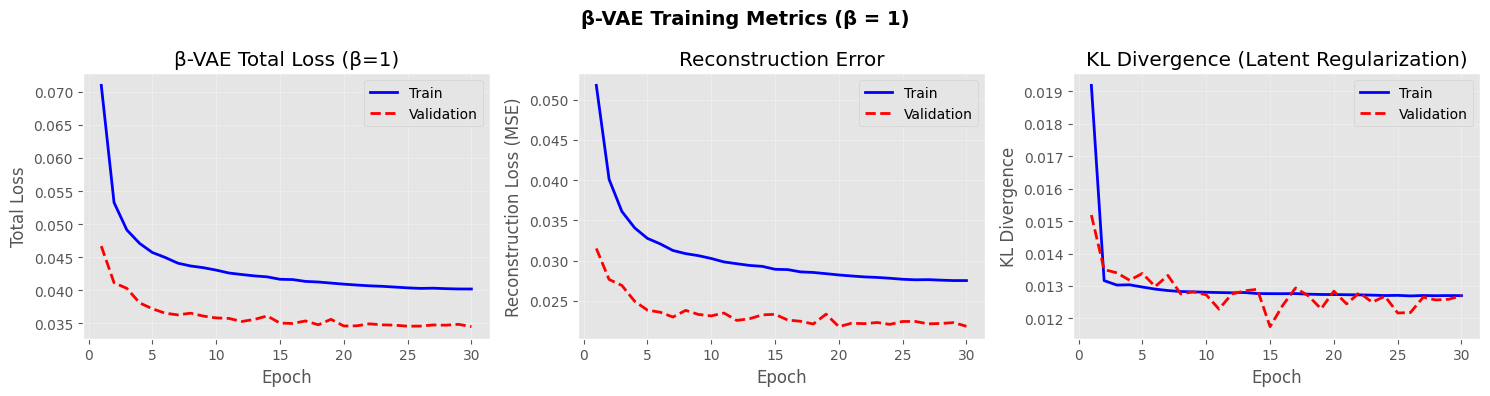

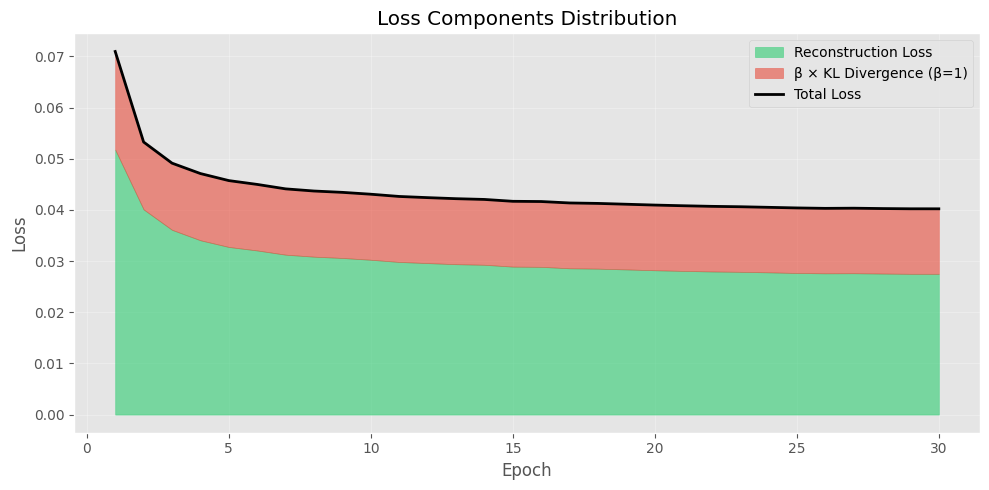

In [19]:
def plot_beta_vae_history(history: dict, beta: float) -> None:
    """Visualizes Beta-VAE training history in detail."""
    epochs = range(1, len(history["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 1. Total Loss
    ax1 = axes[0]
    ax1.plot(epochs, history["train_loss"], 'b-', label="Train", linewidth=2)
    if any(v is not None for v in history.get("val_loss", [])):
        val_losses = [v if v is not None else float("nan") for v in history["val_loss"]]
        ax1.plot(epochs, val_losses, 'r--', label="Validation", linewidth=2)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Total Loss")
    ax1.set_title(f"β-VAE Total Loss (β={beta})")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Reconstruction Loss
    ax2 = axes[1]
    ax2.plot(epochs, history["train_recon"], 'b-', label="Train", linewidth=2)
    if any(v is not None for v in history.get("val_recon", [])):
        val_recon = [v if v is not None else float("nan") for v in history["val_recon"]]
        ax2.plot(epochs, val_recon, 'r--', label="Validation", linewidth=2)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Reconstruction Loss (MSE)")
    ax2.set_title("Reconstruction Error")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. KL Divergence
    ax3 = axes[2]
    ax3.plot(epochs, history["train_kld"], 'b-', label="Train", linewidth=2)
    if any(v is not None for v in history.get("val_kld", [])):
        val_kld = [v if v is not None else float("nan") for v in history["val_kld"]]
        ax3.plot(epochs, val_kld, 'r--', label="Validation", linewidth=2)
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("KL Divergence")
    ax3.set_title("KL Divergence (Latent Regularization)")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.suptitle(f"β-VAE Training Metrics (β = {beta})", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Loss components comparison
    fig2, ax = plt.subplots(figsize=(10, 5))

    # Data for stacked area chart
    train_recon = np.array(history["train_recon"])
    train_kld_weighted = np.array(history["train_kld"]) * beta

    ax.fill_between(epochs, 0, train_recon, alpha=0.6, label=f'Reconstruction Loss', color='#2ecc71')
    ax.fill_between(epochs, train_recon, train_recon + train_kld_weighted, alpha=0.6,
                    label=f'β × KL Divergence (β={beta})', color='#e74c3c')
    ax.plot(epochs, history["train_loss"], 'k-', label='Total Loss', linewidth=2)

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Loss Components Distribution")
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_beta_vae_history(history, CONFIG["beta"])


## β-VAE Latent Space Analysis

In this section, we will analyze the latent space learned by Beta-VAE:
1. **t-SNE Visualization**: Class-wise distribution of latent vectors in 2D
2. **Latent Traversal**: Effect of each latent dimension on generated images
3. **Random Sampling**: Image generation by random sampling from latent space
4. **Latent Statistics**: μ and σ distributions


Extracting latent representations (CPU safe mode)...
This may take a while...
  Processed samples: 32/1000
  Processed samples: 352/1000
  Processed samples: 672/1000
  Processed samples: 992/1000

Latent shape: (1000, 64)

--- PCA Visualization ---
Computing PCA... (data shape: (1000, 64))
PCA completed (explained variance: 64.47%)


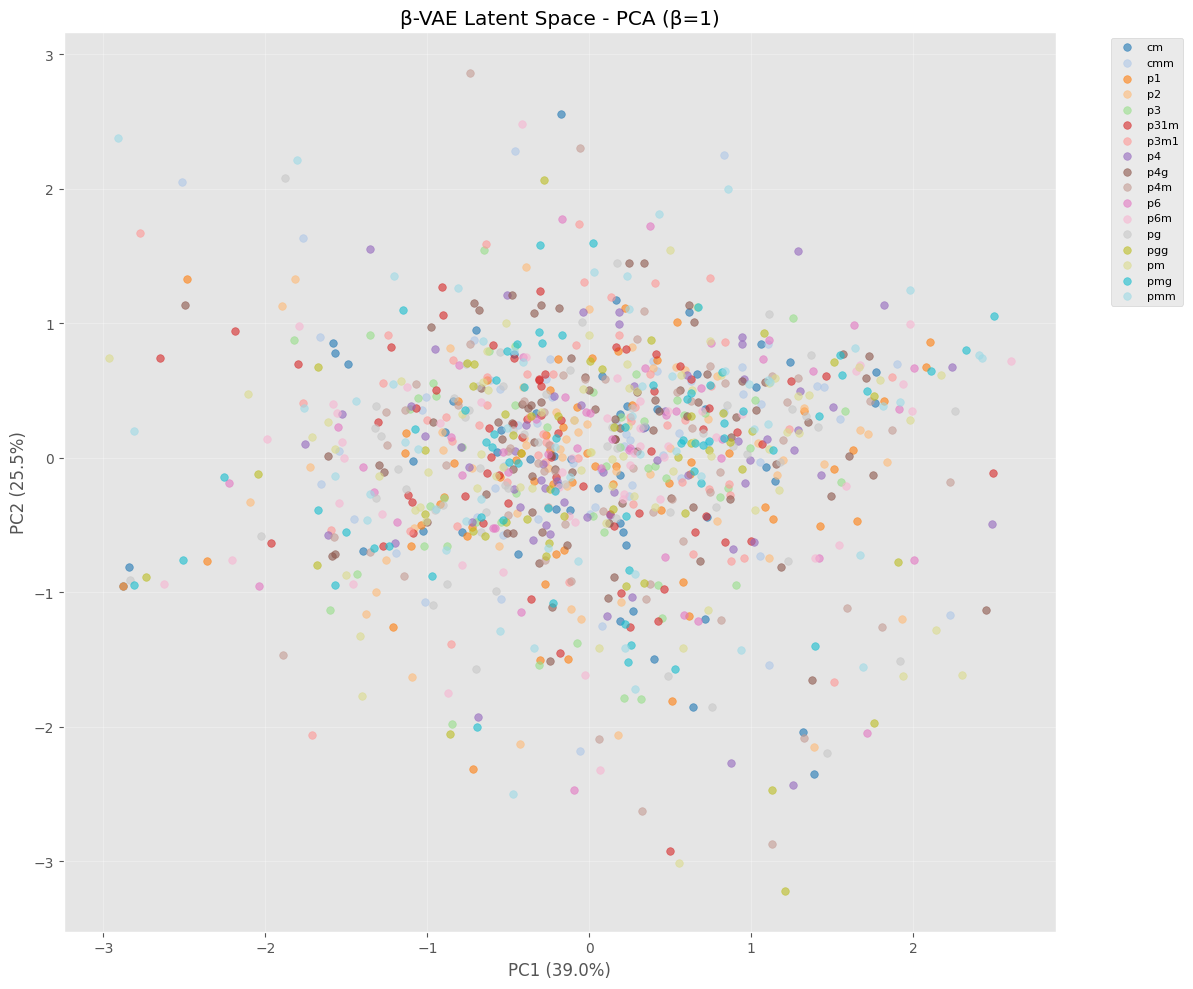

In [20]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import gc

def extract_latent_representations_safe(model: nn.Module, loader: DataLoader, max_samples: int = 500):
    """
    Safe latent extraction function for MPS/CUDA.
    Uses small batches and explicit cleanup to prevent memory issues.
    """
    model.eval()

    all_mu = []
    all_logvar = []
    all_labels = []

    sample_count = 0

    # For memory cleanup after each batch
    for batch_idx, (images, labels) in enumerate(loader):
        if sample_count >= max_samples:
            break

        # Take only what we need
        remaining = max_samples - sample_count
        if images.size(0) > remaining:
            images = images[:remaining]
            labels = labels[:remaining]

        try:
            with torch.no_grad():
                # Process on CPU (to prevent MPS memory issues)
                images_cpu = images.to('cpu')
                model_cpu = model.to('cpu')

                _, mu, logvar = model_cpu(images_cpu)

                # Global Average Pooling: (B, C, H, W) -> (B, C)
                mu_pooled = mu.mean(dim=[2, 3]).numpy()
                logvar_pooled = logvar.mean(dim=[2, 3]).numpy()

                all_mu.append(mu_pooled.copy())
                all_logvar.append(logvar_pooled.copy())
                all_labels.extend(labels.tolist())

                sample_count += images.size(0)

                # Explicit cleanup
                del images_cpu, mu, logvar, mu_pooled, logvar_pooled

        except Exception as e:
            print(f"Error processing batch {batch_idx}: {e}")
            continue

        # Show progress every 10 batches
        if batch_idx % 10 == 0:
            print(f"  Processed samples: {sample_count}/{max_samples}")

        # Memory cleanup
        gc.collect()

    # Move model back to DEVICE
    model.to(DEVICE)

    return np.vstack(all_mu), np.vstack(all_logvar), np.array(all_labels)


def plot_latent_pca(mu: np.ndarray, labels: np.ndarray, class_names: list, title: str = "PCA Latent Space"):
    """PCA visualization of latent space (faster and more stable than t-SNE)."""
    print(f"Computing PCA... (data shape: {mu.shape})")

    pca = PCA(n_components=2, random_state=42)
    latent_2d = pca.fit_transform(mu)
    print(f"PCA completed (explained variance: {pca.explained_variance_ratio_.sum():.2%})")

    # Color palette
    unique_labels = np.unique(labels)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    plt.figure(figsize=(12, 10))
    for idx, label in enumerate(unique_labels):
        mask = labels == label
        plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1],
                   c=[colors[idx]], label=class_names[label], alpha=0.6, s=30)

    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return latent_2d, pca


def plot_latent_tsne_safe(mu: np.ndarray, labels: np.ndarray, class_names: list, title: str = "t-SNE Latent Space"):
    """t-SNE visualization (with fewer samples)."""
    # Subsample if too many samples
    max_for_tsne = 500
    if len(mu) > max_for_tsne:
        print(f"Subsampling for t-SNE: {len(mu)} -> {max_for_tsne} samples...")
        indices = np.random.choice(len(mu), max_for_tsne, replace=False)
        mu_sub = mu[indices]
        labels_sub = labels[indices]
    else:
        mu_sub = mu
        labels_sub = labels

    print(f"Computing t-SNE... (data shape: {mu_sub.shape})")

    perplexity = min(30, max(5, len(mu_sub) // 10))
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=500)
    latent_2d = tsne.fit_transform(mu_sub)
    print("t-SNE completed!")

    # Color palette
    unique_labels = np.unique(labels_sub)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    plt.figure(figsize=(12, 10))
    for idx, label in enumerate(unique_labels):
        mask = labels_sub == label
        plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1],
                   c=[colors[idx]], label=class_names[label], alpha=0.6, s=30)

    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return latent_2d


# Extract latent representations (safely on CPU)
print("Extracting latent representations (CPU safe mode)...")
print("This may take a while...")
mu_all, logvar_all, labels_all = extract_latent_representations_safe(model, train_loader, max_samples=1000)
print(f"\nLatent shape: {mu_all.shape}")

# PCA visualization (fast and stable - recommended for Apple Silicon)
print("\n--- PCA Visualization ---")
latent_2d_pca, pca_model = plot_latent_pca(mu_all, labels_all, metadata["class_names"],
                                            title=f"β-VAE Latent Space - PCA (β={CONFIG['beta']})")

# NOTE: t-SNE may cause kernel crash on Apple Silicon (MPS).
# If you want to use t-SNE, uncomment the lines below and restart the kernel.
# In that case, it's recommended to reduce max_samples to 200.

# print("\n--- t-SNE Visualization ---")
# latent_2d_tsne = plot_latent_tsne_safe(mu_all, labels_all, metadata["class_names"],
#                                         title=f"β-VAE Latent Space - t-SNE (β={CONFIG['beta']})")


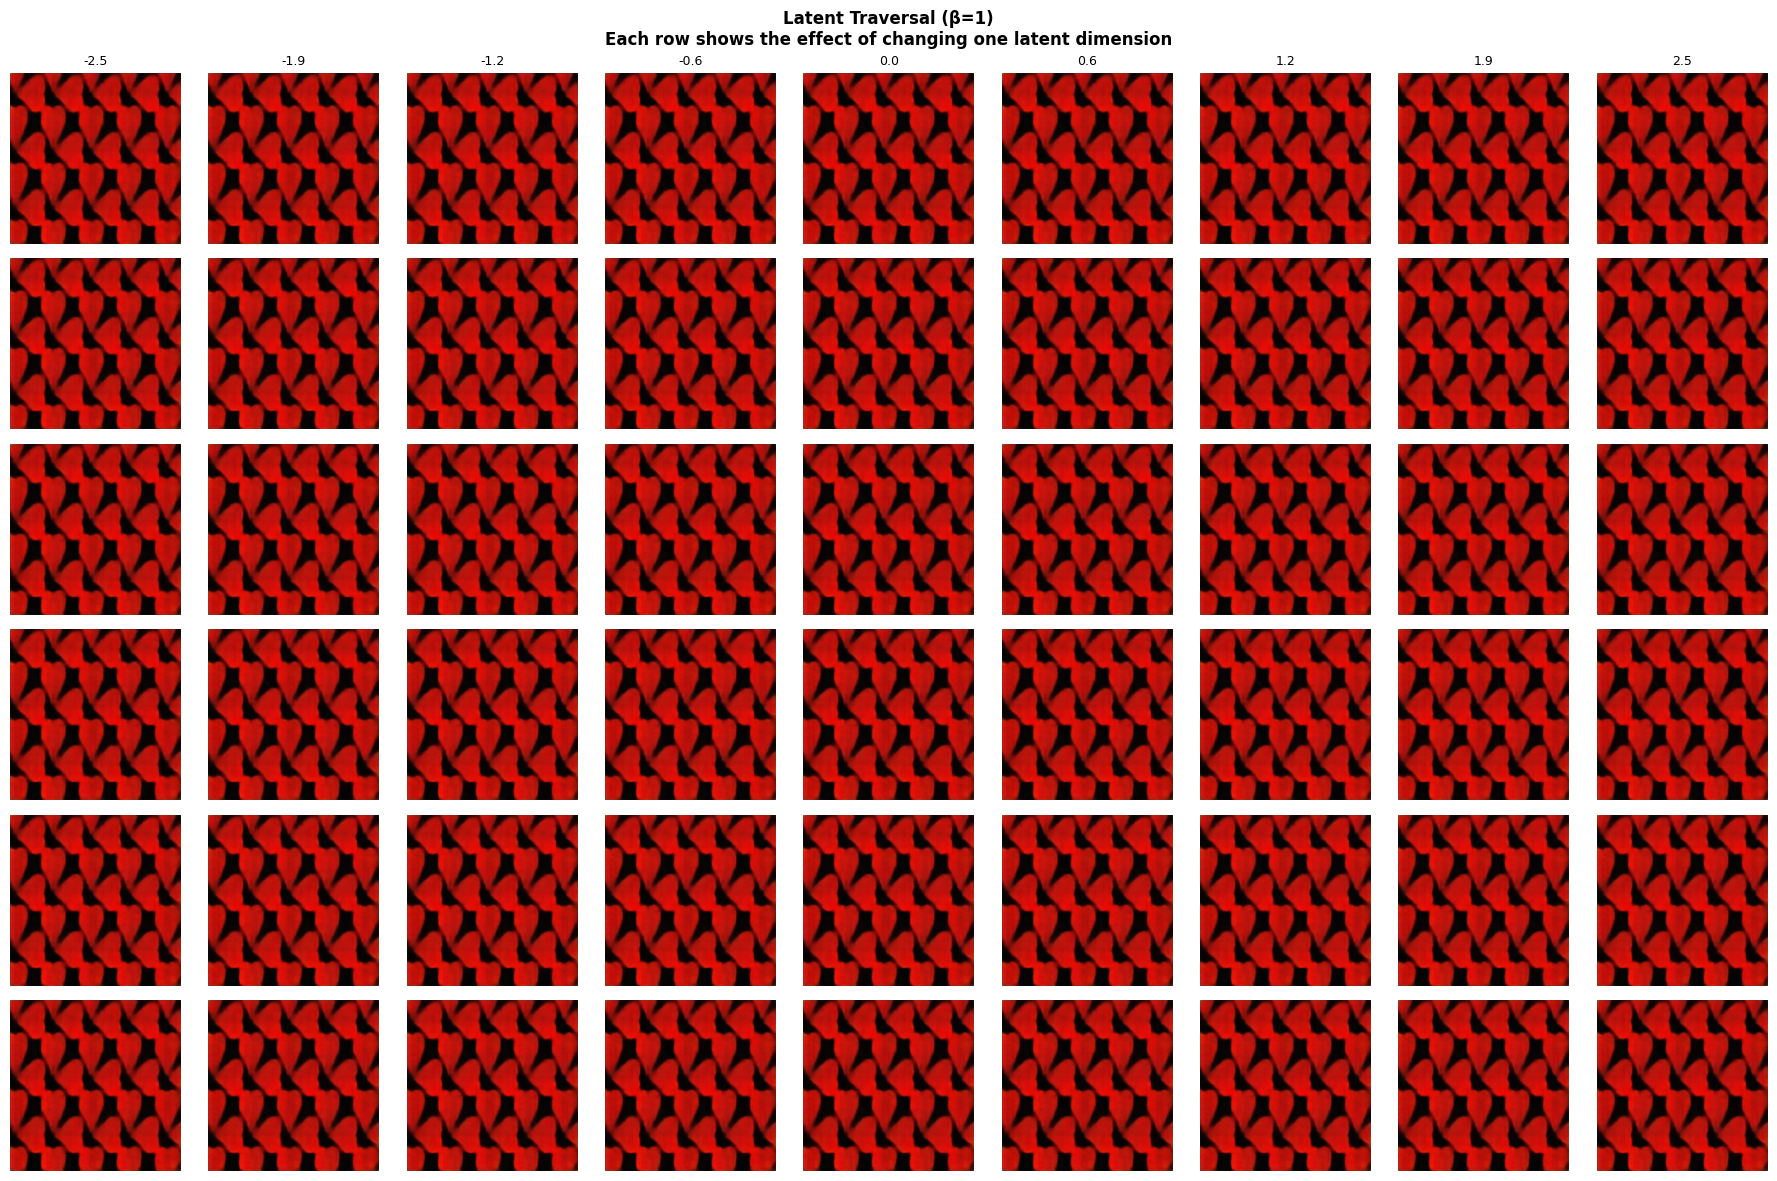

In [21]:
def latent_traversal(model: nn.Module, loader: DataLoader, config: dict,
                     num_dims: int = 8, num_steps: int = 7, range_val: float = 3.0):
    """
    Shows how images change by modifying a single dimension in latent space.
    This is used to analyze Beta-VAE's disentanglement property.
    """
    model.eval()

    # Get reference image
    images, _ = next(iter(loader))
    ref_image = images[0:1].to(DEVICE)

    with torch.no_grad():
        # Encode
        h = model.encoder_body(ref_image)
        encoded = model.encoder_bn(model.encoder_head(h))
        mu, logvar = torch.chunk(encoded, 2, dim=1)

        # Latent shape: (1, C, H, W) - spatial latent
        latent_shape = mu.shape

        # Find most effective dimensions (those with highest variance)
        mu_flat = mu.view(1, -1)

        # Linspace for traversal
        traversal_range = torch.linspace(-range_val, range_val, num_steps).to(DEVICE)

        # Perform traversal for each dimension
        fig, axes = plt.subplots(num_dims, num_steps, figsize=(num_steps * 2, num_dims * 2))

        for dim_idx in range(min(num_dims, mu_flat.shape[1])):
            for step_idx, val in enumerate(traversal_range):
                # Copy original mu
                z = mu.clone()

                # Modify dimension using flat indexing
                z_flat = z.view(1, -1)
                z_flat[0, dim_idx] = val
                z = z_flat.view(latent_shape)

                # Decode
                recon = model.decoder(z)
                recon = denormalize(recon, config["normalize_mean"], config["normalize_std"]).cpu()

                img = recon[0].permute(1, 2, 0).numpy()
                if img.shape[2] == 1:
                    img = img.squeeze(-1)
                    axes[dim_idx, step_idx].imshow(img, cmap='gray')
                else:
                    axes[dim_idx, step_idx].imshow(img)

                axes[dim_idx, step_idx].axis('off')
                if step_idx == 0:
                    axes[dim_idx, step_idx].set_ylabel(f'Dim {dim_idx}', fontsize=10)
                if dim_idx == 0:
                    axes[dim_idx, step_idx].set_title(f'{val:.1f}', fontsize=9)

    plt.suptitle(f'Latent Traversal (β={config["beta"]})\nEach row shows the effect of changing one latent dimension',
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Latent traversal visualization
latent_traversal(model, test_loader, CONFIG, num_dims=6, num_steps=9, range_val=2.5)


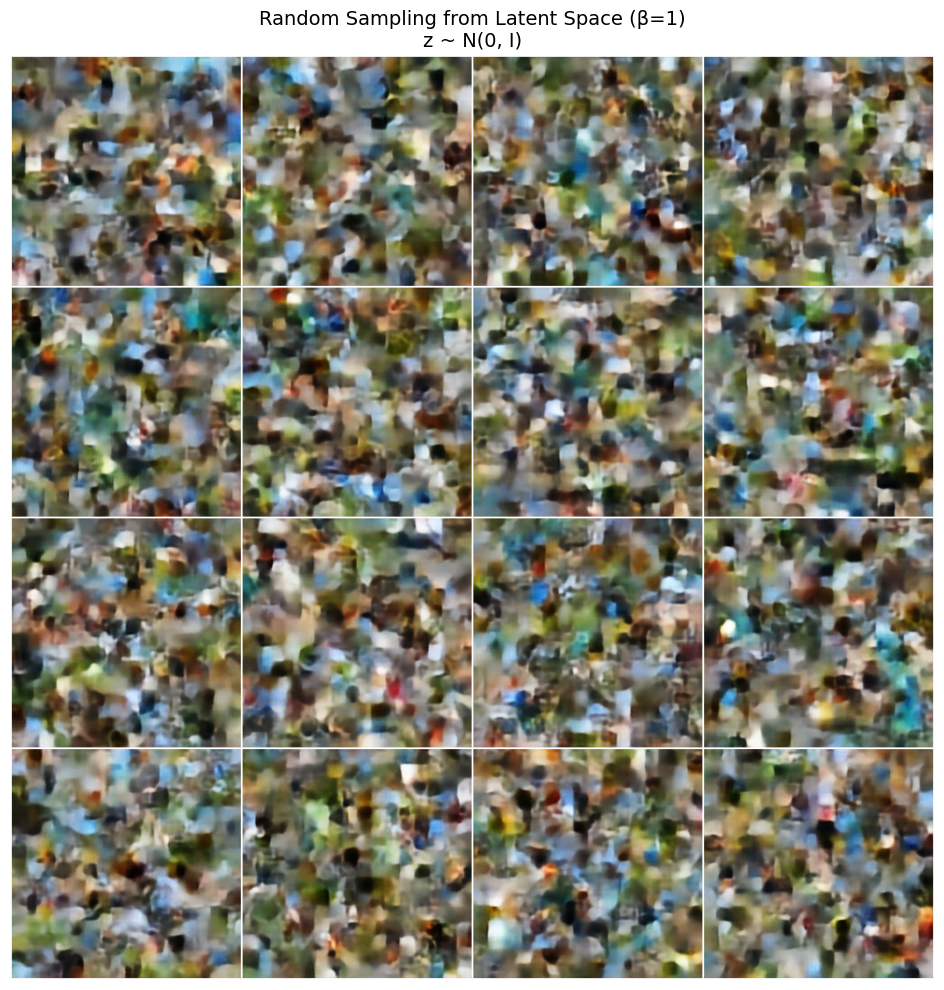

In [22]:
def random_sampling(model: nn.Module, config: dict, num_samples: int = 16, latent_shape: tuple = None):
    """
    Generates new images by random sampling from latent space.
    Tests Beta-VAE's generative capacity.
    """
    model.eval()

    if latent_shape is None:
        # Default latent shape (based on encoder output)
        # For 256x256 image: 256 -> 128 -> 64 -> 32 -> 16 (4 stride-2 conv)
        h, w = config["image_size"][0] // 16, config["image_size"][1] // 16
        latent_shape = (num_samples, config["latent_channels"], h, w)

    with torch.no_grad():
        # Sample from standard normal distribution (VAE's prior)
        z = torch.randn(latent_shape).to(DEVICE)

        # Decode
        generated = model.decoder(z)
        generated = denormalize(generated, config["normalize_mean"], config["normalize_std"]).cpu()

    # Display as grid
    nrow = int(np.sqrt(num_samples))
    grid = utils.make_grid(generated, nrow=nrow, pad_value=1.0)
    grid_np = grid.permute(1, 2, 0).numpy()

    if grid_np.shape[2] == 1:
        grid_np = grid_np.squeeze(-1)
        cmap = 'gray'
    else:
        cmap = None

    plt.figure(figsize=(10, 10))
    plt.imshow(grid_np, cmap=cmap)
    plt.axis('off')
    plt.title(f'Random Sampling from Latent Space (β={config["beta"]})\nz ~ N(0, I)', fontsize=14)
    plt.tight_layout()
    plt.show()

    return generated


# Image generation via random sampling
generated_samples = random_sampling(model, CONFIG, num_samples=16)


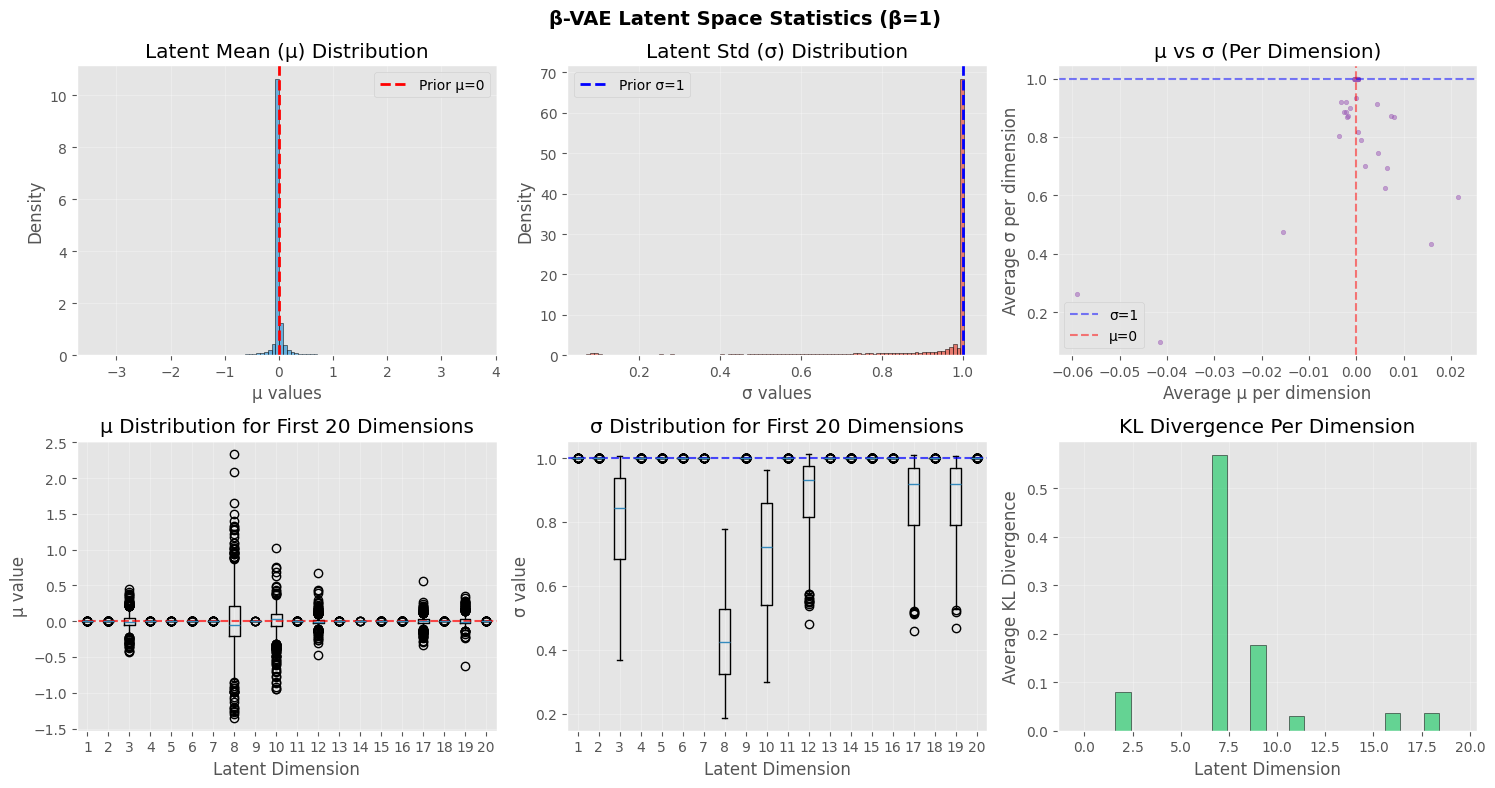


LATENT SPACE STATISTICS
Total latent dimensions: 64
μ - Mean: -0.0009, Std: 0.2010
σ - Mean: 0.9042, Std: 0.1983
Total KL Divergence (per sample): 6.2983


In [23]:
def plot_latent_statistics(mu: np.ndarray, logvar: np.ndarray, beta: float):
    """Visualizes μ and σ distributions of latent space."""

    # σ = exp(0.5 * logvar)
    sigma = np.exp(0.5 * logvar)

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # 1. μ histogram
    ax1 = axes[0, 0]
    ax1.hist(mu.flatten(), bins=100, density=True, alpha=0.7, color='#3498db', edgecolor='black')
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Prior μ=0')
    ax1.set_xlabel('μ values')
    ax1.set_ylabel('Density')
    ax1.set_title('Latent Mean (μ) Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. σ histogram
    ax2 = axes[0, 1]
    ax2.hist(sigma.flatten(), bins=100, density=True, alpha=0.7, color='#e74c3c', edgecolor='black')
    ax2.axvline(x=1, color='blue', linestyle='--', linewidth=2, label='Prior σ=1')
    ax2.set_xlabel('σ values')
    ax2.set_ylabel('Density')
    ax2.set_title('Latent Std (σ) Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. μ vs σ scatter
    ax3 = axes[0, 2]
    # Average μ and σ per dimension
    mu_per_dim = mu.mean(axis=0)
    sigma_per_dim = sigma.mean(axis=0)
    ax3.scatter(mu_per_dim, sigma_per_dim, alpha=0.5, s=10, c='#9b59b6')
    ax3.axhline(y=1, color='blue', linestyle='--', alpha=0.5, label='σ=1')
    ax3.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='μ=0')
    ax3.set_xlabel('Average μ per dimension')
    ax3.set_ylabel('Average σ per dimension')
    ax3.set_title('μ vs σ (Per Dimension)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Per-dimension μ box plot
    ax4 = axes[1, 0]
    # For first 20 dimensions
    sample_dims = min(20, mu.shape[1])
    ax4.boxplot([mu[:, i] for i in range(sample_dims)], vert=True)
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax4.set_xlabel('Latent Dimension')
    ax4.set_ylabel('μ value')
    ax4.set_title(f'μ Distribution for First {sample_dims} Dimensions')
    ax4.grid(True, alpha=0.3)

    # 5. Per-dimension σ box plot
    ax5 = axes[1, 1]
    ax5.boxplot([sigma[:, i] for i in range(sample_dims)], vert=True)
    ax5.axhline(y=1, color='blue', linestyle='--', alpha=0.7)
    ax5.set_xlabel('Latent Dimension')
    ax5.set_ylabel('σ value')
    ax5.set_title(f'σ Distribution for First {sample_dims} Dimensions')
    ax5.grid(True, alpha=0.3)

    # 6. KL Divergence per dimension
    ax6 = axes[1, 2]
    # KL = -0.5 * (1 + log(var) - mu^2 - var)
    kl_per_sample = -0.5 * (1 + logvar - mu**2 - np.exp(logvar))
    kl_per_dim = kl_per_sample.mean(axis=0)
    ax6.bar(range(sample_dims), kl_per_dim[:sample_dims], color='#2ecc71', edgecolor='black', alpha=0.7)
    ax6.set_xlabel('Latent Dimension')
    ax6.set_ylabel('Average KL Divergence')
    ax6.set_title(f'KL Divergence Per Dimension')
    ax6.grid(True, alpha=0.3)

    plt.suptitle(f'β-VAE Latent Space Statistics (β={beta})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n" + "="*60)
    print("LATENT SPACE STATISTICS")
    print("="*60)
    print(f"Total latent dimensions: {mu.shape[1]}")
    print(f"μ - Mean: {mu.mean():.4f}, Std: {mu.std():.4f}")
    print(f"σ - Mean: {sigma.mean():.4f}, Std: {sigma.std():.4f}")
    print(f"Total KL Divergence (per sample): {kl_per_sample.sum(axis=1).mean():.4f}")
    print("="*60)


# Visualize latent statistics
plot_latent_statistics(mu_all, logvar_all, CONFIG["beta"])


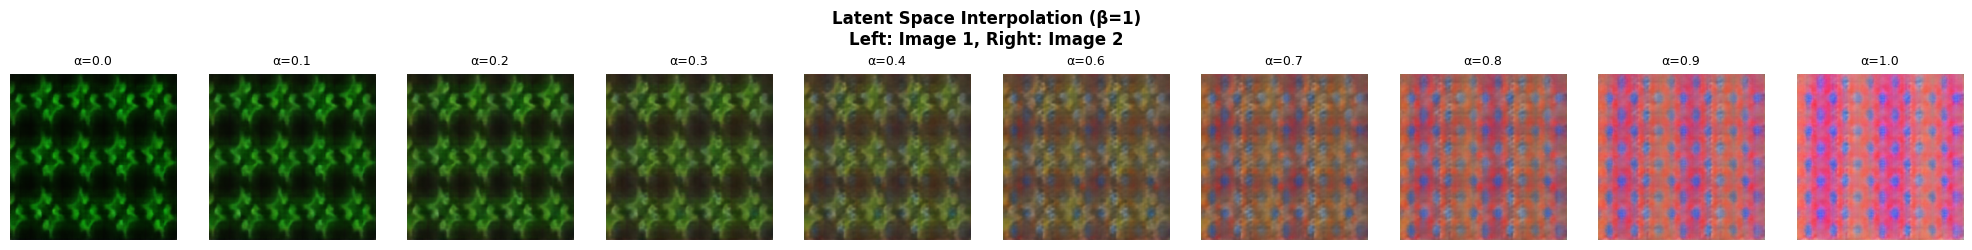

In [39]:
def latent_interpolation(model: nn.Module, loader: DataLoader, config: dict, num_steps: int = 10):
    """
    Performs interpolation in latent space between two images.
    Smooth transitions indicate a well-organized latent space.
    """
    model.eval()

    # Get two different images
    images, labels = next(iter(loader))
    img1, img2 = images[20:21].to(DEVICE), images[9:10].to(DEVICE)

    with torch.no_grad():
        # Encode both images
        h1 = model.encoder_body(img1)
        encoded1 = model.encoder_bn(model.encoder_head(h1))
        mu1, _ = torch.chunk(encoded1, 2, dim=1)

        h2 = model.encoder_body(img2)
        encoded2 = model.encoder_bn(model.encoder_head(h2))
        mu2, _ = torch.chunk(encoded2, 2, dim=1)

        # Linear interpolation
        alphas = torch.linspace(0, 1, num_steps).to(DEVICE)
        interpolated_images = []

        for alpha in alphas:
            z = (1 - alpha) * mu1 + alpha * mu2
            recon = model.decoder(z)
            recon = denormalize(recon, config["normalize_mean"], config["normalize_std"]).cpu()
            interpolated_images.append(recon)

        interpolated = torch.cat(interpolated_images, dim=0)

    # Visualize
    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 2.5))

    for idx in range(num_steps):
        img = interpolated[idx].permute(1, 2, 0).numpy()
        if img.shape[2] == 1:
            img = img.squeeze(-1)
            axes[idx].imshow(img, cmap='gray')
        else:
            axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'α={alphas[idx]:.1f}', fontsize=9)

    plt.suptitle(f'Latent Space Interpolation (β={config["beta"]})\nLeft: Image 1, Right: Image 2',
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Latent interpolation
latent_interpolation(model, test_loader, CONFIG, num_steps=10)


## Test Set Evaluation and Class-wise Analysis

In the following cells, model performance will be evaluated on the test set and class-wise reconstruction errors will be reported.


In [25]:
from collections import defaultdict


def reconstruction_errors_by_class(model: nn.Module, loader: DataLoader) -> dict:
    model.eval()
    criterion = nn.MSELoss(reduction="none")
    class_errors = defaultdict(list)

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE, non_blocking=True)
            # BetaVAE model returns (reconstruction, mu, logvar) tuple
            outputs, _, _ = model(images)
            loss_map = criterion(outputs, images)
            per_sample = loss_map.view(loss_map.size(0), -1).mean(dim=1)

            for idx, label in enumerate(labels.tolist()):
                class_errors[label].append(per_sample[idx].item())

    return class_errors


def summarize_class_errors(class_errors: dict, class_names: list[str]) -> list[tuple[str, float, float]]:
    summary = []
    for class_idx, errors in class_errors.items():
        errors_array = np.array(errors)
        summary.append(
            (
                class_names[class_idx],
                float(errors_array.mean()),
                float(errors_array.std()),
            )
        )
    summary.sort(key=lambda x: x[1])
    return summary


In [26]:
# evaluate_loss function expects config dictionary
test_loss = evaluate_loss(model, test_loader, CONFIG)
print(f"Test VAE loss: {test_loss:.6f}")

class_errors = reconstruction_errors_by_class(model, test_loader)
class_summary = summarize_class_errors(class_errors, metadata["class_names"])

print("\nClass-wise reconstruction error (mean ± std):")
for name, mean_err, std_err in class_summary:
    print(f"- {name}: {mean_err:.6f} ± {std_err:.6f}")


Test VAE loss: 0.155442

Class-wise reconstruction error (mean ± std):
- p1: 0.070367 ± 0.055601
- pm: 0.088343 ± 0.074099
- cm: 0.089018 ± 0.059490
- pmg: 0.096758 ± 0.063404
- p3m1: 0.101526 ± 0.066394
- p3: 0.113996 ± 0.081382
- p31m: 0.121127 ± 0.066045
- p2: 0.125733 ± 0.097608
- p4m: 0.128415 ± 0.054793
- cmm: 0.128547 ± 0.124025
- pg: 0.134883 ± 0.108223
- p4g: 0.137333 ± 0.094188
- pmm: 0.142475 ± 0.104441
- pgg: 0.158648 ± 0.154222
- p6m: 0.167456 ± 0.118347
- p4: 0.180626 ± 0.166072
- p6: 0.193823 ± 0.142434


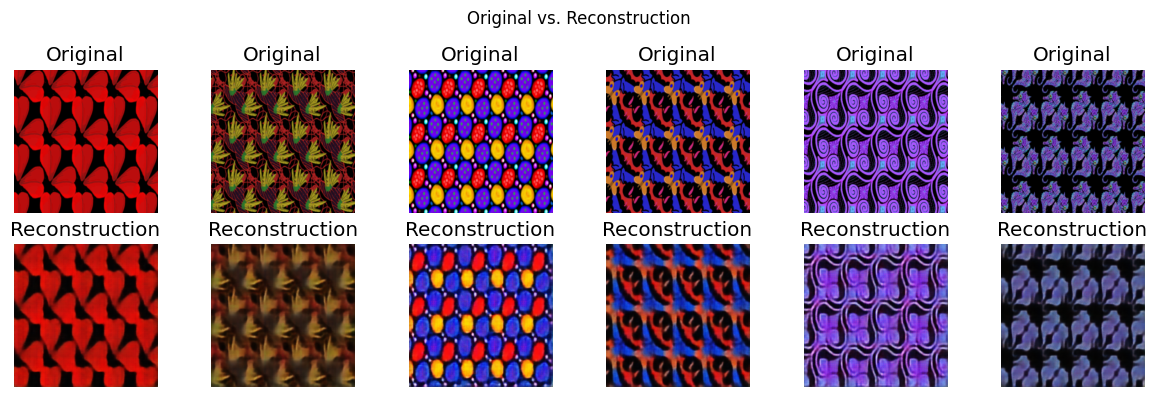

In [27]:
def visualize_reconstructions(model: nn.Module, loader: DataLoader, config: dict, num_images: int = 8) -> None:
    model.eval()
    images, labels = next(iter(loader))
    images = images[:num_images].to(DEVICE, non_blocking=True)

    with torch.no_grad():
        # BetaVAE model returns (reconstruction, mu, logvar) tuple
        reconstructions, _, _ = model(images)

    images = denormalize(images, config["normalize_mean"], config["normalize_std"]).cpu()
    reconstructions = denormalize(reconstructions, config["normalize_mean"], config["normalize_std"]).cpu()

    rows = 2
    cols = num_images
    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 4))

    for idx in range(num_images):
        original = images[idx].permute(1, 2, 0).numpy()
        recon = reconstructions[idx].permute(1, 2, 0).numpy()

        if original.shape[2] == 1:
            original = original.squeeze(-1)
            recon = recon.squeeze(-1)
            cmap = "gray"
        else:
            cmap = None

        axes[0, idx].imshow(original, cmap=cmap)
        axes[0, idx].axis("off")
        axes[0, idx].set_title("Original")

        axes[1, idx].imshow(recon, cmap=cmap)
        axes[1, idx].axis("off")
        axes[1, idx].set_title("Reconstruction")

    fig.suptitle("Original vs. Reconstruction")
    plt.tight_layout()
    plt.show()


visualize_reconstructions(model, test_loader, CONFIG, num_images=6)


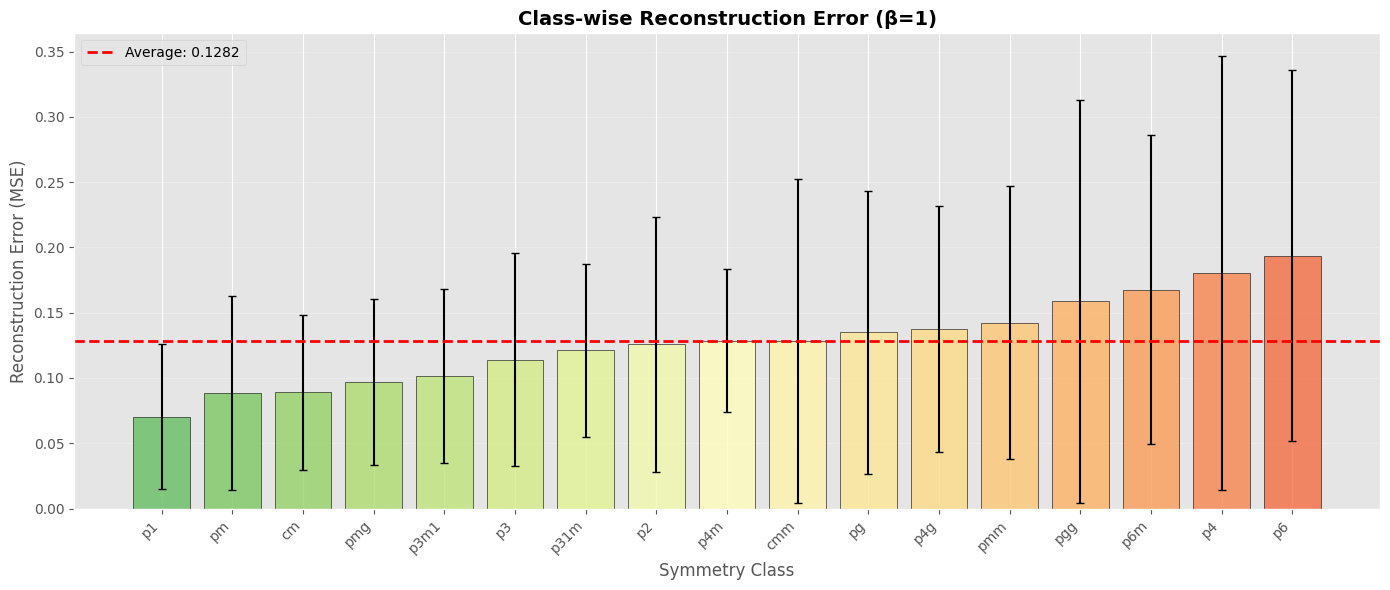

In [28]:
def plot_class_errors_bar(class_summary: list, title: str = "Class-wise Reconstruction Error"):
    """Visualizes class-wise errors as bar chart."""
    names = [x[0] for x in class_summary]
    means = [x[1] for x in class_summary]
    stds = [x[2] for x in class_summary]

    fig, ax = plt.subplots(figsize=(14, 6))

    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(names)))
    bars = ax.bar(range(len(names)), means, yerr=stds, capsize=3, color=colors, edgecolor='black', alpha=0.8)

    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=10)
    ax.set_xlabel('Symmetry Class')
    ax.set_ylabel('Reconstruction Error (MSE)')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)

    # Average line
    avg = np.mean(means)
    ax.axhline(y=avg, color='red', linestyle='--', linewidth=2, label=f'Average: {avg:.4f}')
    ax.legend()

    plt.tight_layout()
    plt.show()


# Class-wise error chart
plot_class_errors_bar(class_summary, title=f"Class-wise Reconstruction Error (β={CONFIG['beta']})")


In [29]:
def generate_beta_vae_report(model: nn.Module, config: dict, metadata: dict, history: dict,
                              test_loss: float, class_summary: list, mu: np.ndarray, logvar: np.ndarray):
    """Generates a comprehensive summary report for Beta-VAE."""

    sigma = np.exp(0.5 * logvar)
    kl_per_sample = -0.5 * (1 + logvar - mu**2 - np.exp(logvar))
    avg_kl = kl_per_sample.sum(axis=1).mean()

    # Best and worst classes
    best_class = class_summary[0]
    worst_class = class_summary[-1]

    # Val loss format (may be None)
    val_loss_str = f"{history['val_loss'][-1]:.6f}" if history['val_loss'][-1] is not None else 'N/A'

    report = f"""
{'='*70}
               β-VAE MODEL REPORT - SYMMETRY CLASSIFICATION
{'='*70}

📊 MODEL CONFIGURATION
{'-'*70}
  • Model Type:           Beta Variational Autoencoder (β-VAE)
  • Beta (β) Value:       {config['beta']}
  • Image Size:           {config['image_size'][0]}x{config['image_size'][1]}
  • Num Channels:         {config['num_channels']}
  • Latent Channels:      {config['latent_channels']}
  • Base Channels:        {config['base_channels']}
  • Parameters:           {count_parameters(model):,}

📈 TRAINING INFO
{'-'*70}
  • Training Samples:     {metadata['train_size']:,}
  • Validation Samples:   {metadata['val_size']:,}
  • Test Samples:         {metadata['test_size']:,}
  • Num Classes:          {len(metadata['class_names'])}
  • Num Epochs:           {len(history['train_loss'])}
  • Learning Rate:        {config['learning_rate']}
  • Batch Size:           {config['batch_size']}

📉 TRAINING RESULTS
{'-'*70}
  • Final Train Loss:     {history['train_loss'][-1]:.6f}
  • Final Recon Loss:     {history['train_recon'][-1]:.6f}
  • Final KL Loss:        {history['train_kld'][-1]:.6f}
  • Final Val Loss:       {val_loss_str}

🎯 TEST PERFORMANCE
{'-'*70}
  • Test VAE Loss:        {test_loss:.6f}
  • Best Class:           {best_class[0]} (MSE: {best_class[1]:.6f})
  • Worst Class:          {worst_class[0]} (MSE: {worst_class[1]:.6f})

🔬 LATENT SPACE ANALYSIS
{'-'*70}
  • Total Latent Dims:    {mu.shape[1]}
  • μ Mean:               {mu.mean():.4f} (Ideal: 0)
  • μ Std:                {mu.std():.4f}
  • σ Mean:               {sigma.mean():.4f} (Ideal: 1)
  • σ Std:                {sigma.std():.4f}
  • Avg KL Divergence:    {avg_kl:.4f}

💡 β-VAE INTERPRETATION
{'-'*70}
"""

    if config['beta'] > 1:
        beta_comment = f"""  β = {config['beta']} > 1: Model prioritizes disentanglement.
  This leads to latent dimensions learning more independent features,
  but reconstruction quality may decrease."""
    elif config['beta'] < 1:
        beta_comment = f"""  β = {config['beta']} < 1: Model prioritizes reconstruction quality.
  Images are better reconstructed, but latent space
  may be less organized."""
    else:
        beta_comment = """  β = 1.0: Standard VAE behavior. Reconstruction and
  latent regularization are balanced."""

    report += beta_comment

    report += f"""

{'='*70}
                         END OF REPORT
{'='*70}
"""

    print(report)

    # Save report to file
    report_path = config['output_dir'] / 'beta_vae_report.txt'
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(report)
    print(f"\n📄 Report saved: {report_path}")


# Generate comprehensive report
generate_beta_vae_report(
    model=model,
    config=CONFIG,
    metadata=metadata,
    history=history,
    test_loss=test_loss,
    class_summary=class_summary,
    mu=mu_all,
    logvar=logvar_all
)



               β-VAE MODEL REPORT - SYMMETRY CLASSIFICATION

📊 MODEL CONFIGURATION
----------------------------------------------------------------------
  • Model Type:           Beta Variational Autoencoder (β-VAE)
  • Beta (β) Value:       1
  • Image Size:           256x256
  • Num Channels:         3
  • Latent Channels:      64
  • Base Channels:        32
  • Parameters:           464,931

📈 TRAINING INFO
----------------------------------------------------------------------
  • Training Samples:     76,500
  • Validation Samples:   8,500
  • Test Samples:         355
  • Num Classes:          17
  • Num Epochs:           30
  • Learning Rate:        0.001
  • Batch Size:           32

📉 TRAINING RESULTS
----------------------------------------------------------------------
  • Final Train Loss:     0.040207
  • Final Recon Loss:     0.027504
  • Final KL Loss:        0.012703
  • Final Val Loss:       0.034520

🎯 TEST PERFORMANCE
-----------------------------------------------

In [30]:
!zip -r /content/artifacts.zip /content/artifacts

  adding: content/artifacts/ (stored 0%)
  adding: content/artifacts/beta_vae_report.txt (deflated 67%)
  adding: content/artifacts/best_autoencoder.pt (deflated 7%)


In [48]:
# Colab'deki kaynak klasörünüzün yolu (örnek: /content/veri_klasoru)
SOURCE_FOLDER = '/content/artifacts'

# Google Drive'daki hedef yolunuz. Drive'ınızın ana dizini '/content/drive/MyDrive/'dır.
# Buraya kopyalanacak klasör, Drive'ınızda 'Backups/my_data_folder' olarak görünecektir.
DESTINATION_PATH = '/content/drive/MyDrive/'

# '-r' (recursive) flag'i ile klasör ve altındaki tüm dosyalar kopyalanır.
!cp -r {SOURCE_FOLDER} {DESTINATION_PATH}

print(f"'{SOURCE_FOLDER}' klasörü, '{DESTINATION_PATH}' konumuna kopyalanmıştır.")

'/content/artifacts' klasörü, '/content/drive/MyDrive/' konumuna kopyalanmıştır.


## Conclusion and Recommendations

### About β-VAE
β-VAE (Beta Variational Autoencoder) is an extended version of the standard VAE. The key difference is the β coefficient applied to the KL divergence term in the ELBO (Evidence Lower Bound) formula:

$$\mathcal{L}_{\beta-VAE} = \mathbb{E}[\log p(x|z)] - \beta \cdot D_{KL}(q(z|x) || p(z))$$

### Effect of β Value
- **β > 1**: Stronger latent regularization → More disentangled representations, but blurrier reconstruction
- **β < 1**: Weaker regularization → Sharper reconstruction, but more entangled latent space
- **β = 1**: Standard VAE

### Next Steps
1. **Try different β values**: Compare with values like β = [0.1, 0.5, 1.0, 2.0, 4.0]
2. **Adjust latent dimension size**: Experiment with more/fewer latent channels
3. **Disentanglement metrics**: Add metrics like DCI, Factor VAE metric
4. **Conditional β-VAE**: Add class information as condition for more controlled generation

### References
- Higgins et al., "β-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework" (ICLR 2017)
- Burgess et al., "Understanding disentangling in β-VAE" (2018)
